<a href="https://colab.research.google.com/github/warriors8970/XAI/blob/main/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ResNet Model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import pandas as pd
import numpy as np
from keras.applications import ResNet50

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 224;

### Creating base model

In [ ]:

INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3]
base_model = ResNet50(input_shape=INPUT_SHAPE,  weights='imagenet', include_top=False)

In [ ]:
from keras import layers
for layer in base_model.layers:
  layer.trainable = False

Flattened_l = layers.Flatten()(base_model.output)

output_layer = layers.Dense(10, activation = 'softmax')(Flattened_l)

final_model = tf.keras.models.Model(inputs = base_model.input, outputs = output_layer)

In [ ]:
final_model.summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

## Custom functions:

- `make_gradcam_heatmap()`:
  - Create a sub-model - This takes input of original model and outputs **feature maps** and **final preds**
  - Usage of **Gradient Tape** - Used to compute gradients wrt the feature maps of the respective layers
  - Calculate gradients
  - Convert GradientTape values in the form of Heatmap

In [ ]:
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model that outputs the feature maps and final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        # If pred_index is not specified, use the predicted class index
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalise the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

- `display_gradcam()`
  - Take heatmap as input and rescale it in the range of (0-255)
  - Transform heatmap into image
  - Resize the heatmap to match image dimensions
  - Draw the heatmap on original image

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Transform
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)

    # Resize the heatmap
    jet_heatmap = jet_heatmap.resize((img.shape[2], img.shape[1]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img
    return superimposed_img[0]
    # plt.axis(False)

In [ ]:
import PIL
import numpy as np
import requests

def get_processed_img(image_path):
    # Open the image using the URL
    img_from_url = tf.io.read_file(image_path)

    # Adjust the image dimensions to a standard size.
    new_image = tf.image.resize(img_from_url, size=[IMG_SIZE,IMG_SIZE])

    # Transform the image into a NumPy array.
    processed_image = np.asarray(new_image)

    # Normalise pixel values if necessary
    if processed_image.max() > 1:
        processed_image = processed_image / 255

    # Add a batch dimension
    image = np.expand_dims(processed_image, axis=0)


    return image

### Import custom images

In [ ]:
# Imports
import os
from IPython.display import Image


In [ ]:
import os
custom_path = "drive/MyDrive/Dog Vision/custom_preds/"
custom_image_paths = [custom_path+ fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['drive/MyDrive/Dog Vision/custom_preds/beagle.jpg',
 'drive/MyDrive/Dog Vision/custom_preds/husky.jpg']

In [ ]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

def process_image(image_path, img_size = IMG_SIZE):
  #read the filepath
  image = tf.io.read_file(image_path)
  #convert jpeg to tensors with 3 color channels
  image = tf.image.decode_jpeg(image, channels=3)
  #convert color channels form 0-255 to 0-1
  image = tf.image.convert_image_dtype(image,tf.float32)
  #resize the image
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])
  return image

def create_data_batches(X,y=None,batch_size = BATCH_SIZE, valid_data = False, test_data= False):
  # if data in test dataset, we dont have labels
    if test_data:
      print("Creating test data batches...")
      data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))#only filepaths
      data_batch = data.map(process_image).batch(BATCH_SIZE)
      return data_batch

    # if data in valid dataset, we dont need to shuffle
    elif valid_data:
      print("Creating valid data batches...")
      data = tf.data.Dataset.from_tensor_slices((tf.constant(X),# filepaths
                                                 tf.constant(y))) # labels
      data_batch = data.map(get_image_label).batch(BATCH_SIZE)
      return data_batch

    else:
      print("Creating training data batches...")
      # turn filepaths into tensors
      data =tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                           tf.constant(y)))
      # shuffle before mapping
      data = data.shuffle(buffer_size = len(X))# buffer_size is the total size to be shuffled
      data = data.map(get_image_label)# map the labels
      data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
processed_image = process_image(custom_image_paths[0])

In [ ]:
processed_image_numpy = np.expand_dims(processed_image, axis=0)
processed_image_numpy.shape

(1, 224, 224, 3)

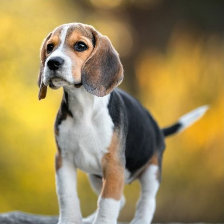

In [ ]:
import torch
from PIL import Image
import numpy as np

processed = Image.fromarray(np.uint8(processed_image_numpy.squeeze() * 255), 'RGB')

processed

(-0.5, 6.5, 6.5, -0.5)

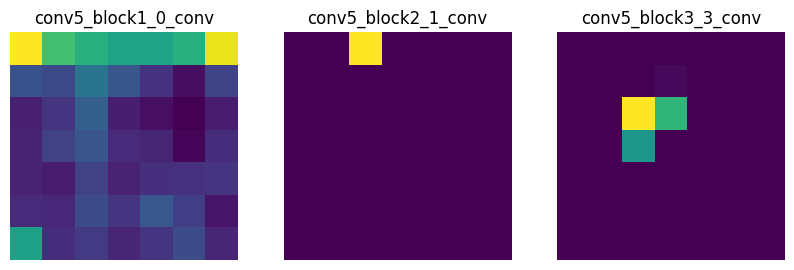

In [ ]:
heatmap1 = make_gradcam_heatmap(processed_image_numpy, final_model, 'conv5_block1_0_conv')
heatmap2 = make_gradcam_heatmap(processed_image_numpy, final_model, 'conv5_block2_1_conv')
heatmap3 = make_gradcam_heatmap(processed_image_numpy, final_model, 'conv5_block3_3_conv')

plt.figure(figsize = (10,4))

plt.subplot(1,3,1)
plt.imshow(heatmap1, cmap='viridis')
plt.title("conv5_block1_0_conv")
plt.axis(False)

plt.subplot(1,3,2)
plt.imshow(heatmap2, cmap='viridis')
plt.title("conv5_block2_1_conv")
plt.axis(False)

plt.subplot(1,3,3)
plt.imshow(heatmap3, cmap='viridis')
plt.title("conv5_block3_3_conv")
plt.axis(False)



<ipython-input-65-2566150731fa>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


(-0.5, 223.5, 223.5, -0.5)

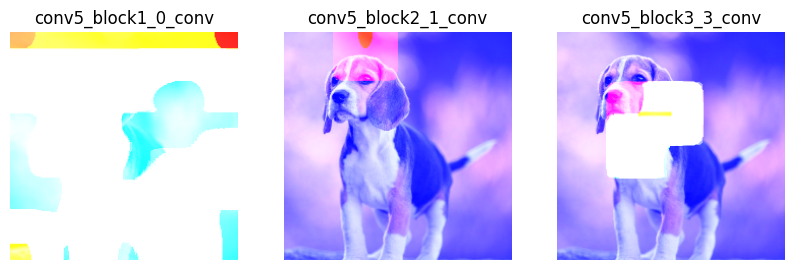

In [ ]:
super1 = display_gradcam(processed_image_numpy, heatmap1)
super2 = display_gradcam(processed_image_numpy, heatmap2)
super3 = display_gradcam(processed_image_numpy, heatmap3)


plt.figure(figsize = (10,4))

plt.subplot(1,3,1)
plt.imshow(super1, cmap='viridis')
plt.title("conv5_block1_0_conv")
plt.axis(False)

plt.subplot(1,3,2)
plt.imshow(super2, cmap='viridis')
plt.title("conv5_block2_1_conv")
plt.axis(False)

plt.subplot(1,3,3)
plt.imshow(super3, cmap='viridis')
plt.title("conv5_block3_3_conv")
plt.axis(False)


# DenseNet Model

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing requirements

In [ ]:
#!pip install tensorflow numpy pillow matplotlib requests


## Creating functions for:
- `get_processed_img()` - Preprocess image url to feed into the model
- `make_gradcam_heatmap()` - Make heatmap with the image array and model
- `display_gradcam()` - display which pixels are important according to gradcam to predict the label

In [ ]:
import PIL
import numpy as np
import requests

def get_processed_img(url):
    # Open the image using the URL
    img_from_url = PIL.Image.open(requests.get(url, stream=True).raw)

    # Adjust the image dimensions to a standard size.
    new_image = img_from_url.resize((224, 224))

    # Transform the image into a NumPy array.
    processed_image = np.asarray(new_image)

    # Normalise pixel values if necessary
    if processed_image.max() > 1:
        processed_image = processed_image / 255

    # Add a batch dimension
    image = np.expand_dims(processed_image, axis=0)

    return image

In [ ]:
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model that outputs the feature maps and final prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)

        # If pred_index is not specified, use the predicted class index
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalise the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
# from tf.keras import layers
# from tf.keras.applications.densenet import DenseNet201

def display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use the "jet" colormap to colourize the heatmap
    jet = cm.get_cmap("jet");
    jet_colors = jet(np.arange(256))[:, :3];
    jet_heatmap = jet_colors[heatmap];

    # Transform the heatmap into an image.
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap);

    # Resize the heatmap to match the image dimensions
    jet_heatmap = jet_heatmap.resize((img.shape[2], img.shape[1]));

    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap);

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img;
    # plt.imshow(superimposed_img[0])
    return superimposed_img[0]


In [ ]:
densenet_model = tf.keras.applications.DenseNet201(include_top=False, input_shape=(224,224,3))

for layer in densenet_model.layers:
  layer.trainable = False

Flattened_layer = tf.keras.layers.Flatten()(densenet_model.output)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(Flattened_layer)

final_model = tf.keras.models.Model(inputs=densenet_model.input, outputs=output_layer)
final_model.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

##Visualizing

Image shape: (528, 360)




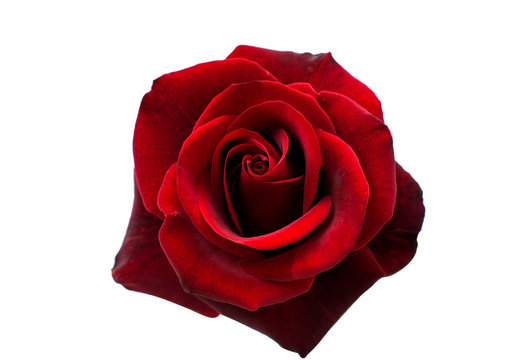

In [ ]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://t3.ftcdn.net/jpg/01/05/57/38/360_F_105573812_cvD4P5jo6tMPhZULX324qUYFbNpXlisD.jpg')
img = Image.open(BytesIO(response.content))
print(f"Image shape: {img.size}\n\n")
img


Image dimensions: (1, 224, 224, 3)


(-0.5, 6.5, 6.5, -0.5)

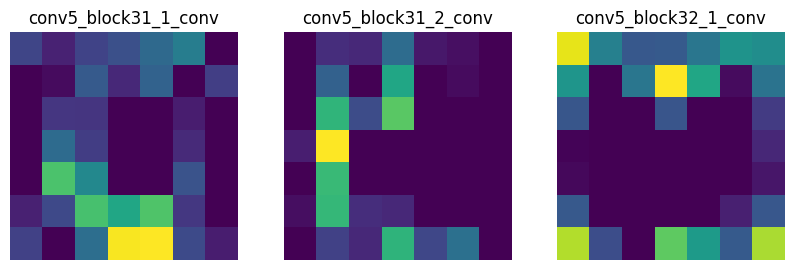

In [ ]:
img_arr = get_processed_img('https://t3.ftcdn.net/jpg/01/05/57/38/360_F_105573812_cvD4P5jo6tMPhZULX324qUYFbNpXlisD.jpg')
print(f"Image dimensions: {img_arr.shape}")
heatmap1_rose = make_gradcam_heatmap(img_arr, final_model, 'conv5_block31_1_conv')
heatmap2_rose = make_gradcam_heatmap(img_arr, final_model, 'conv5_block31_2_conv')
heatmap3_rose = make_gradcam_heatmap(img_arr, final_model, 'conv5_block32_1_conv')

plt.figure(figsize = (10,4))

plt.subplot(1,3,1)
plt.imshow(heatmap1_rose, cmap='viridis')
plt.title("conv5_block31_1_conv")
plt.axis(False)

plt.subplot(1,3,2)
plt.imshow(heatmap2_rose, cmap='viridis')
plt.title("conv5_block31_2_conv")
plt.axis(False)

plt.subplot(1,3,3)
plt.imshow(heatmap3_rose, cmap='viridis')
plt.title("conv5_block32_1_conv")
plt.axis(False)



<ipython-input-80-aaaaebe1e4a0>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


(-0.5, 223.5, 223.5, -0.5)

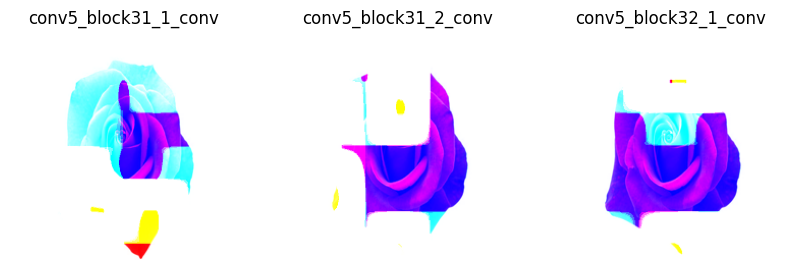

In [ ]:
super1_rose = display_gradcam(img_arr, heatmap1_rose)
super2_rose = display_gradcam(img_arr, heatmap2_rose)
super3_rose = display_gradcam(img_arr, heatmap3_rose)

plt.figure(figsize = (10,4))

plt.subplot(1,3,1)
plt.imshow(super1_rose, cmap='viridis')
plt.title("conv5_block31_1_conv")
plt.axis(False)

plt.subplot(1,3,2)
plt.imshow(super2_rose, cmap='viridis')
plt.title("conv5_block31_2_conv")
plt.axis(False)

plt.subplot(1,3,3)
plt.imshow(super3_rose, cmap='viridis')
plt.title("conv5_block32_1_conv")
plt.axis(False)


# Custom Image in DenseNet



In [ ]:
filename = 'drive/MyDrive/Dog Vision/custom_preds/beagle.jpg'

### Visualizing original Image

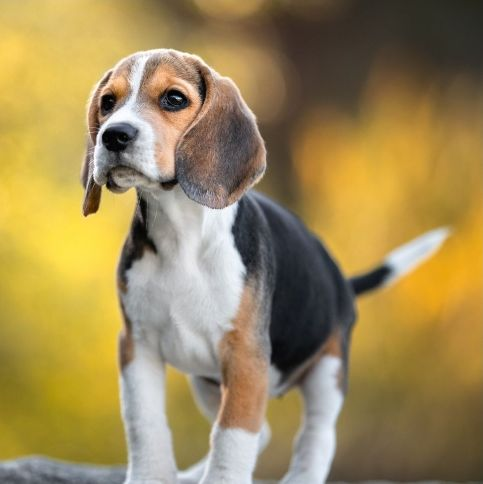

In [ ]:
from IPython.display import Image
Image(filename)


### Modify the original `get_processed_img` function to compute our custom image

In [ ]:
img = tf.io.read_file(filename)
image = tf.image.decode_jpeg(img, channels=3)
#convert color channels form 0-255 to 0-1
image = tf.image.convert_image_dtype(image,tf.float32)
image.shape

TensorShape([484, 483, 3])

In [ ]:
import PIL
import numpy as np
import requests

IMG_SIZE = 224

def get_processed_img(image_path):
    # Open the image using the URL
    img = tf.io.read_file(image_path)

    # Adjust the image dimensions to a standard size.
    image = tf.image.decode_jpeg(img, channels=3)
  #convert color channels form 0-255 to 0-1
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])
    image = np.expand_dims(image, axis=0)

    return image

In [ ]:
procecssed_ = get_processed_img('drive/MyDrive/Dog Vision/custom_preds/beagle.jpg')
procecssed_.shape


(1, 224, 224, 3)

### Visualize the processed image

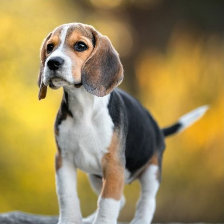

In [ ]:
import torch
from PIL import Image
import numpy as np

img = Image.fromarray(np.uint8(procecssed_.squeeze() * 255), 'RGB')

img


### Visualizing heatmap

(-0.5, 6.5, 6.5, -0.5)

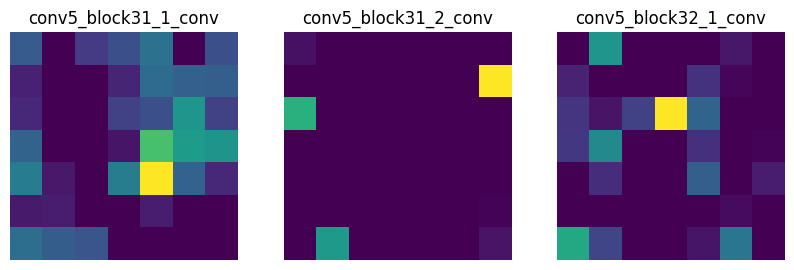

In [ ]:
heatmap1_densenet = make_gradcam_heatmap(procecssed_, final_model, 'conv5_block31_1_conv')
heatmap2_densenet = make_gradcam_heatmap(procecssed_, final_model, 'conv5_block31_2_conv')
heatmap3_densenet = make_gradcam_heatmap(procecssed_, final_model, 'conv5_block32_1_conv')

plt.figure(figsize = (10,4))

plt.subplot(1,3,1)
plt.imshow(heatmap1_densenet, cmap='viridis')
plt.title("conv5_block31_1_conv")
plt.axis(False)

plt.subplot(1,3,2)
plt.imshow(heatmap2_densenet, cmap='viridis')
plt.title("conv5_block31_2_conv")
plt.axis(False)

plt.subplot(1,3,3)
plt.imshow(heatmap3_densenet, cmap='viridis')
plt.title("conv5_block32_1_conv")
plt.axis(False)

### Visualizing gradcam

<ipython-input-99-63294674fd38>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet");


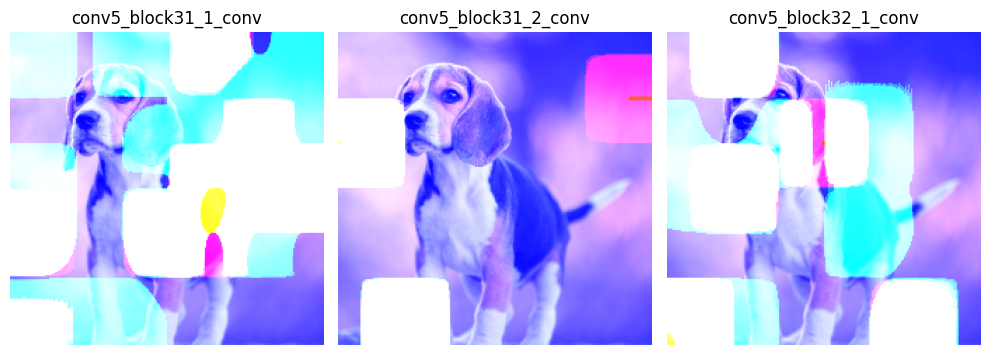

In [ ]:
super1_densenet = display_gradcam(procecssed_, heatmap1_densenet)
super2_densenet = display_gradcam(procecssed_, heatmap2_densenet)
super3_densenet = display_gradcam(procecssed_, heatmap3_densenet)

plt.figure(figsize = (10,4))

plt.subplot(1,3,1)
plt.imshow(super1_densenet, cmap='viridis');
plt.title("conv5_block31_1_conv")
plt.axis(False)

plt.subplot(1,3,2)
plt.imshow(super2_densenet, cmap='viridis')
plt.title("conv5_block31_2_conv")
plt.axis(False)

plt.subplot(1,3,3)
plt.imshow(super3_densenet, cmap='viridis')
plt.title("conv5_block32_1_conv")
plt.axis(False)

plt.tight_layout()
plt.show()

### Thankyou!

